# Restaurant Visitor Forecasting 

This is a Restaurant Visitors dataset that was inspired by a Kaggle competition. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. 

The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

# Library

In [105]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import time_series

%reload_ext autoreload

## Reading data and preprocessing

In [4]:
# Load dataset
df = pd.read_csv(f'E:\gitlab\machine-learning\dataset\RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspecting the data

In [5]:
df.head(10)

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0
2016-01-06,Wednesday,0,na,9.0,11.0,22.0,41.0,83.0
2016-01-07,Thursday,0,na,15.0,6.0,18.0,30.0,69.0
2016-01-08,Friday,0,na,79.0,32.0,22.0,16.0,149.0
2016-01-09,Saturday,0,na,44.0,44.0,47.0,99.0,234.0


## delete nan

In [6]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


We notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

## Change the dtype of selected columns

In [7]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


## Plotting the time series data

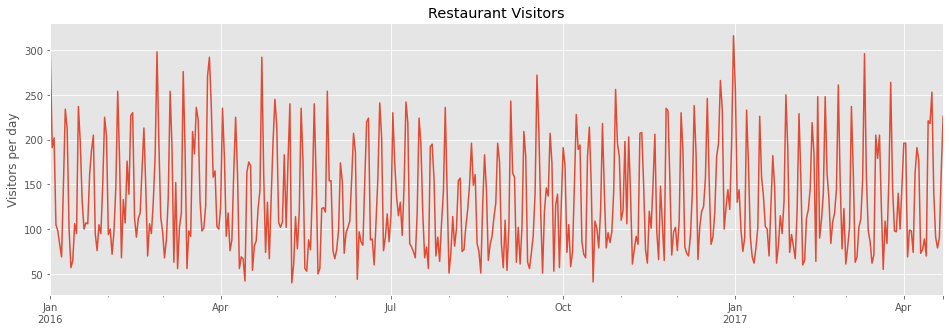

In [9]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

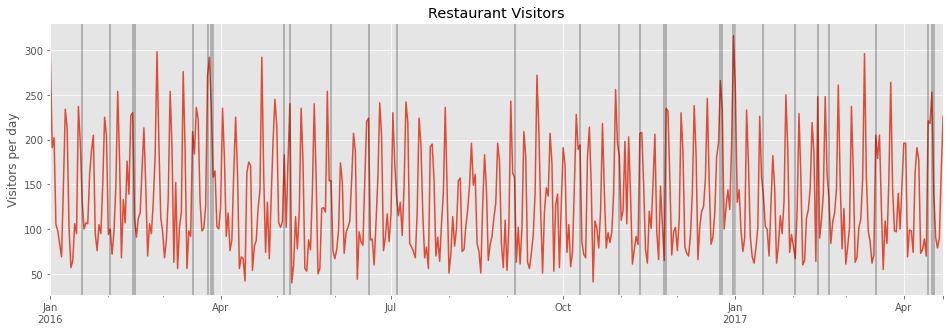

In [10]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' 

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

### ETS decomposition of data 

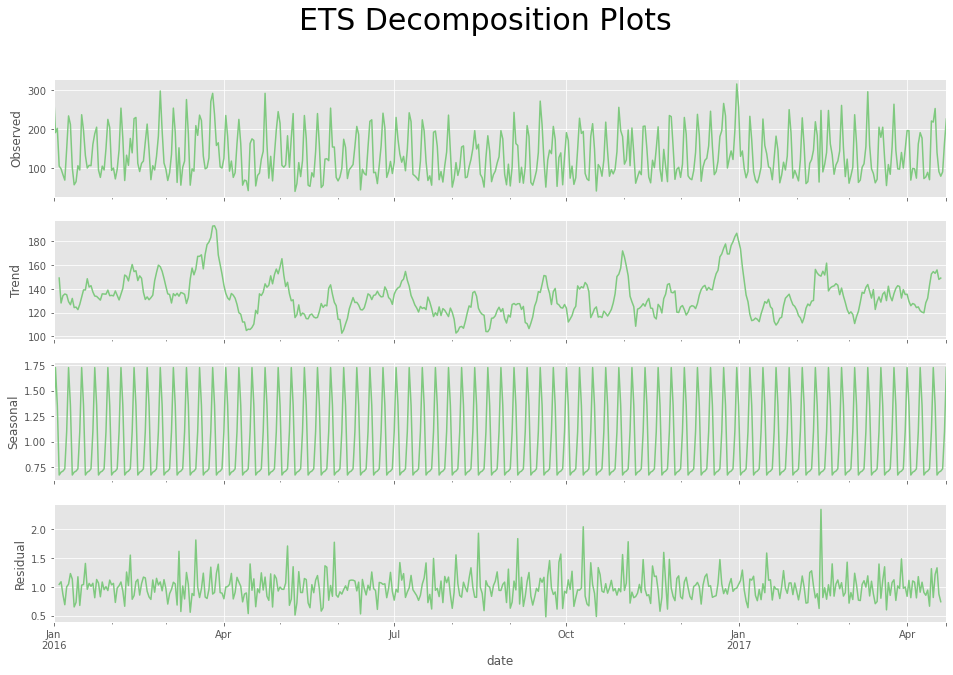

In [19]:
time_series.decomposition_plot(df1,'total','multiplicative')

### Run ADF test to check if data is stationary 

In [21]:
adf_result,adf = time_series.adf_test(df1,'total')

Augmented Dickey-Fuller Test:
p-val of the ADF test in dataset: 1.319377094694142e-06
Augmented Dickey-Fuller Test on Sales Data

ADF test statistic       -5.592497
p-value                   0.000001
#lags used               18.000000
#observations           459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Plot ACF and PACF Plots to get idea of orders

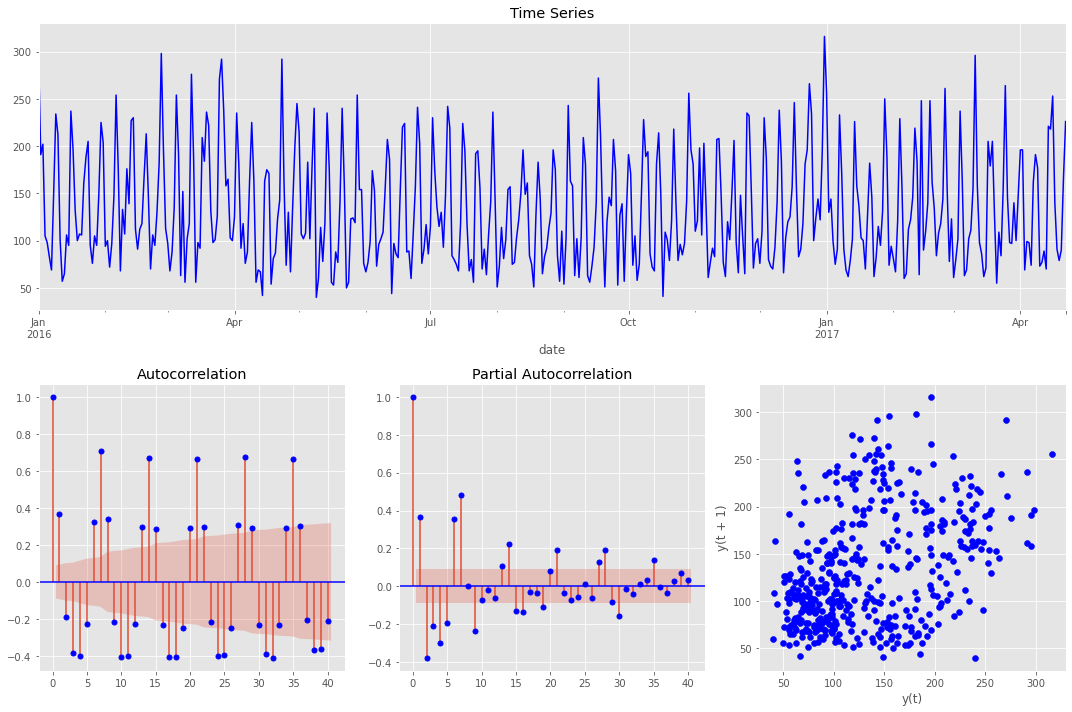

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  478
Model:                     ARMA(1, 0)   Log Likelihood               -2674.748
Method:                           mle   S.D. of innovations             65.042
Date:                Mon, 22 Mar 2021   AIC                           5353.496
Time:                        19:50:50   BIC                           5361.836
Sample:                             0   HQIC                          5356.775
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.9002      0.020     44.487      0.000       0.861       0.940
                                    Roots                                    
                  Real          Imaginary           M

In [22]:
time_series.autocorrelation_plot(df1,'total',40)

The sharp cut-off at lag-1 in the PACF plot and presence of positive correlation in ACF plot at lag-1 indicates AR-1 model.

According to Duke University's Statistical website:

    If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms.
    If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms.



### Run auto_arima from pmdarima to get orders 

In [23]:
time_series.autoarima(df1,'total',7)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2380.595
Date:                   Mon, 22 Mar 2021   AIC                           4769.191
Time:                           19:56:27   BIC                           4785.869
Sample:                                0   HQIC                          4775.748
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7053      1.456      2.545      0.011       0.852       6.559
ar.S.L7        0.9697      0.011     86.031      0.000       0.948       0.992
ma.S.L7       -0.7627      0.048    -15.985      0.000      -0.856      -0.669
sigma2      1201.1092     70.235     17.101      0.000    1063.452    1338.767
===================================================================================
Ljung-Box (Q):                       64.84   Jarque-Bera (JB):                67.41
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.75
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) and a seasonal order of (2,0,0,7). Now we will train & test the SARIMA model, evaluate and then compare the result to a model that uses an exogenous variable.

### Splitting data into training and testing sets 

In [8]:
len(df1)

478

We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [25]:
478-42

436

In [9]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

In [10]:
train

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98
...,...,...,...,...,...,...,...,...
2017-03-07,Tuesday,0,na,28,9,19,13,69
2017-03-08,Wednesday,0,na,27,19,35,21,102
2017-03-09,Thursday,0,na,63,22,13,13,111


### Fitting a SARIMA(1,0,0)(2,0,0,7) Model 

In [27]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Wed, 18 Nov 2020   AIC                           4457.403
Time:                                   10:09:09   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2211      0.047      4.710      0.000       0.129       0.313
ar.S.L7        0.5064      0.036     14.188      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2793     82.276     18.478      0.000    1359.021    1681.537
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Tue, 23 Mar 2021   AIC                           4457.403
Time:                                   16:04:48   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



Evaluating SARIMA Model with test dataset - MSE Error: 1702.65
Evaluating SARIMA Model with test dataset - RMSE Error: 41.26


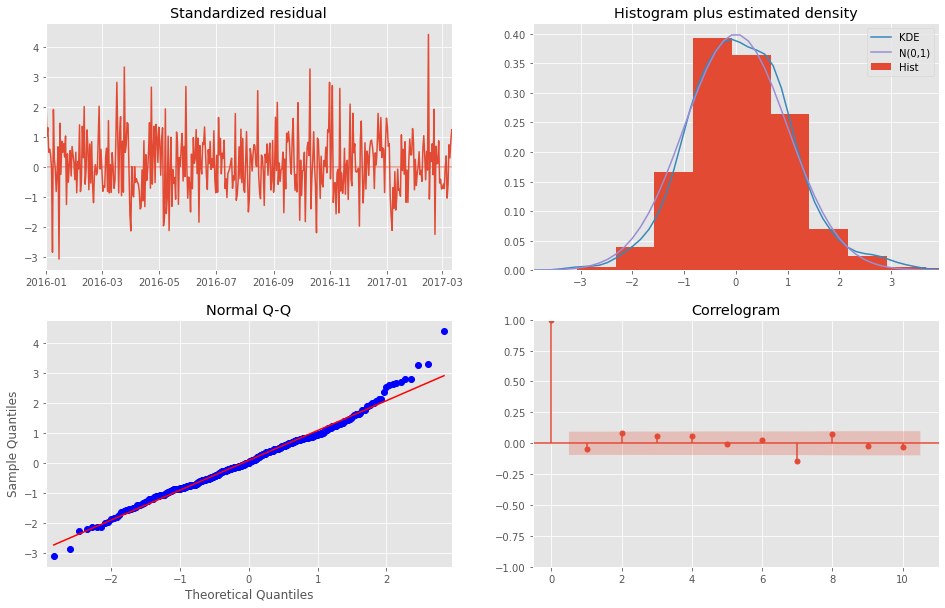

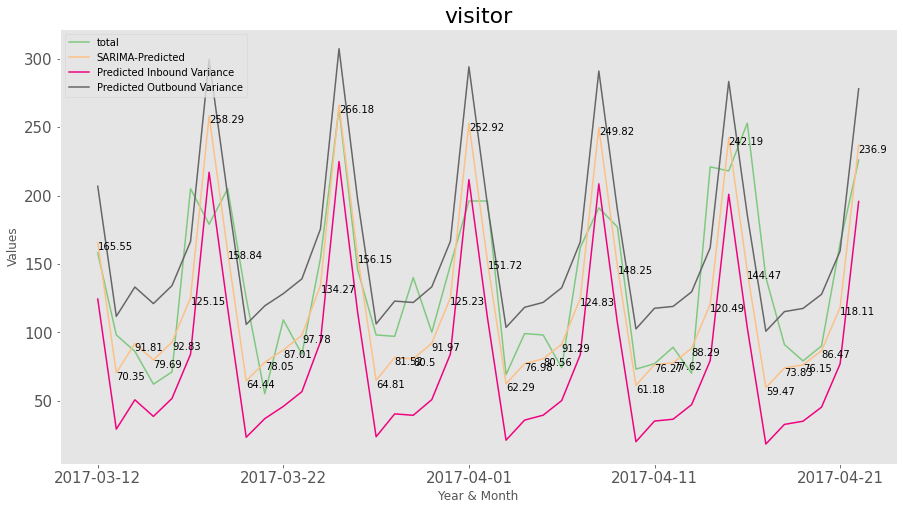

In [365]:
result_1 = time_series.sarimax_model(train,'total',order=(1,0,0),so=(2,0,0,7),title='visitor',test=test)

# Adding the exogenous variable to improve model:

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Tue, 23 Mar 2021   AIC                           4326.963
Time:                                   16:04:51   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8872      4.241     15.773      0.000      58.576      75.199
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.311      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.4035     73.302     15.244      0.000     973.733    1261.074
===================================================================================
Ljung-Box (Q):                      100.96   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



Evaluating SARIMA Model with test dataset - MSE Error: 950.67
Evaluating SARIMA Model with test dataset - RMSE Error: 30.83


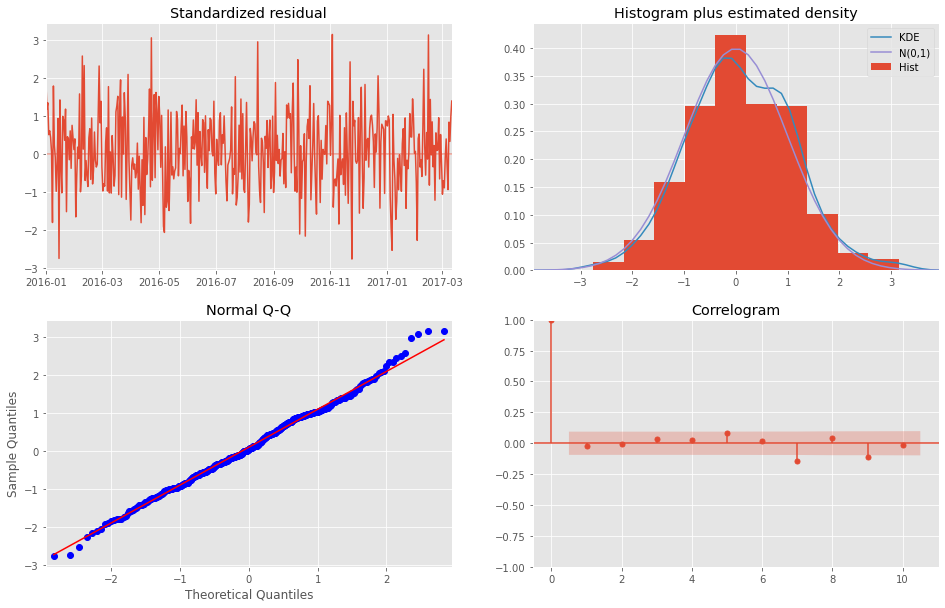

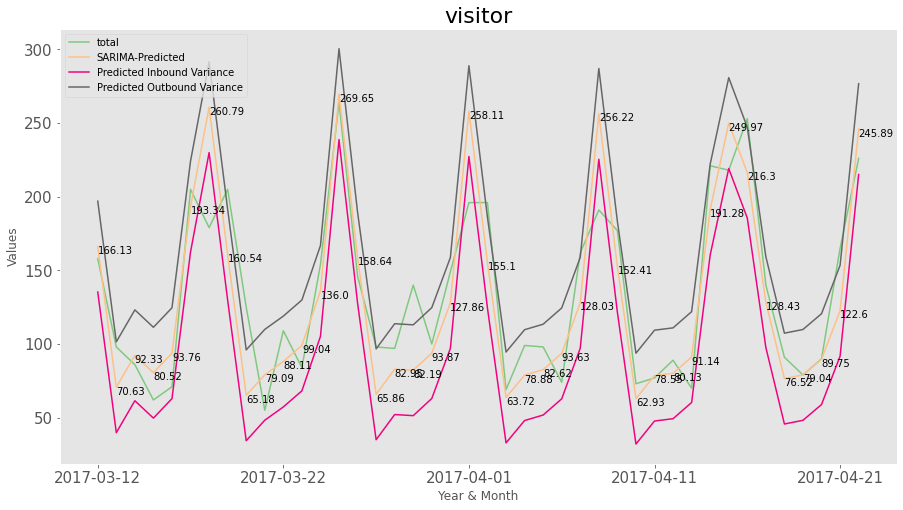

In [366]:
result_2 = time_series.sarimax_model(train,'total',order=(1,0,0),so=(2,0,0,7),title='visitor',exog=True,col_2='holiday',test=test)

# Plot predictions against known values

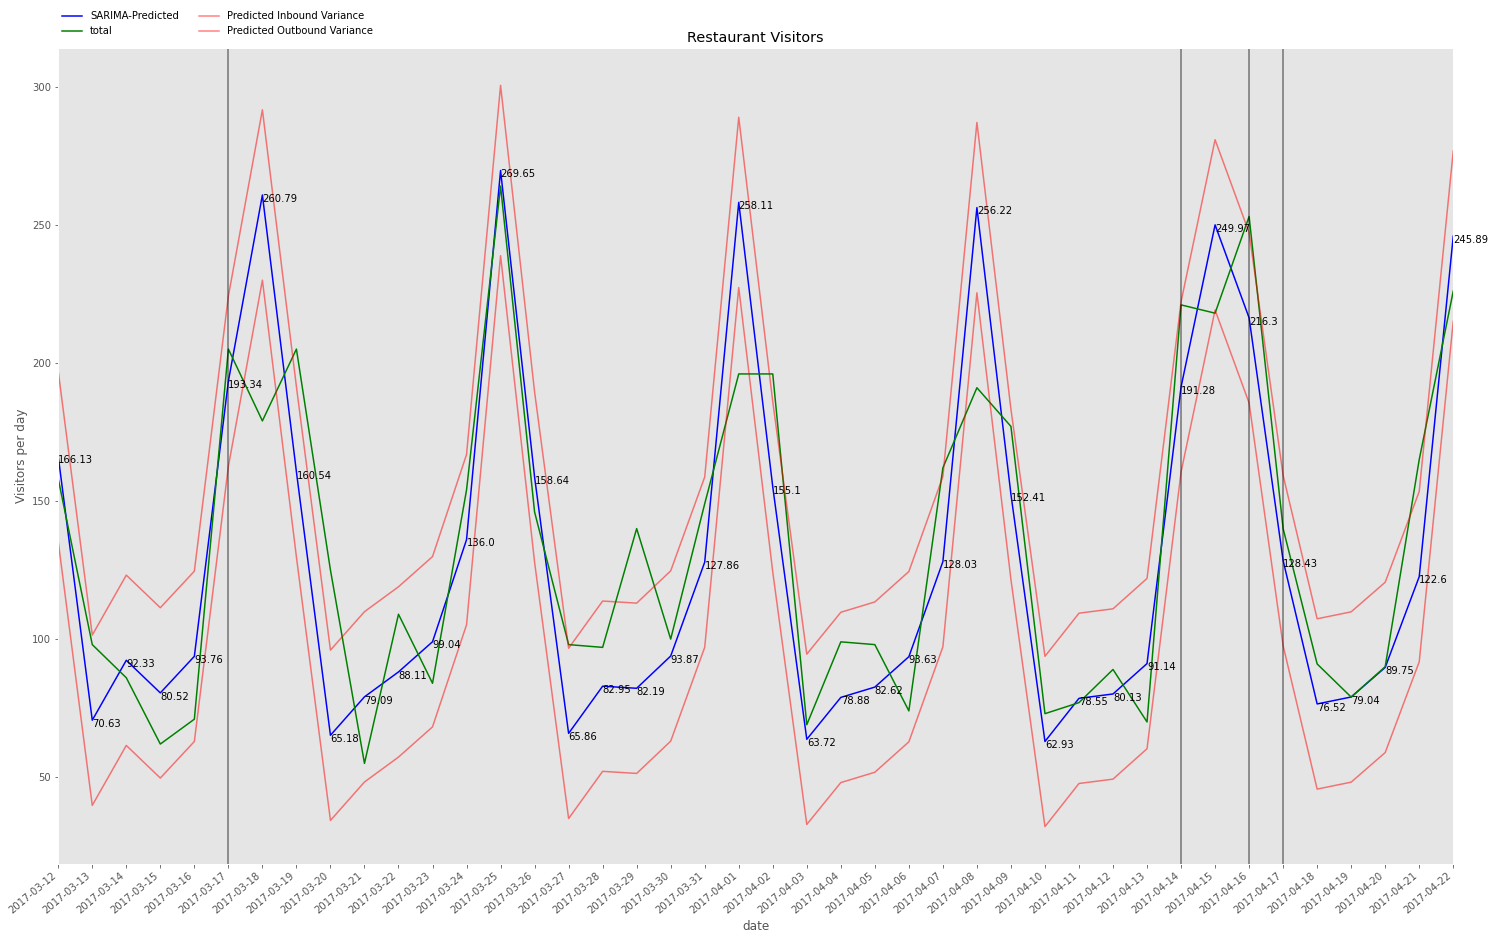

In [367]:
time_series.sarimax_model_plot(result_2,'total','holiday','Restaurant Visitors','date','Visitors per day')

# Re-training the model on full data and predicting into the future 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2359.370
Date:                           Tue, 23 Mar 2021   AIC                           4728.741
Time:                                   15:57:56   BIC                           4749.589
Sample:                               01-01-2016   HQIC                          4736.937
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       67.5852      4.123     16.393      0.000      59.504      75.666
ar.L1          0.1930      0.046      4.178      0.000       0.102       0.284
ar.S.L7        0.5028      0.039     12.984      0.000       0.427       0.579
ar.S.L14       0.4706      0.039     12.168      0.000       0.395       0.546
sigma2      1088.5038     67.375     16.156      0.000     956.450    1220.557
===================================================================================
Ljung-Box (Q):                      106.09   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.00   Prob(JB):                         0.53
Heteroskedasticity (H):               0.86   Skew:                             0.08
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

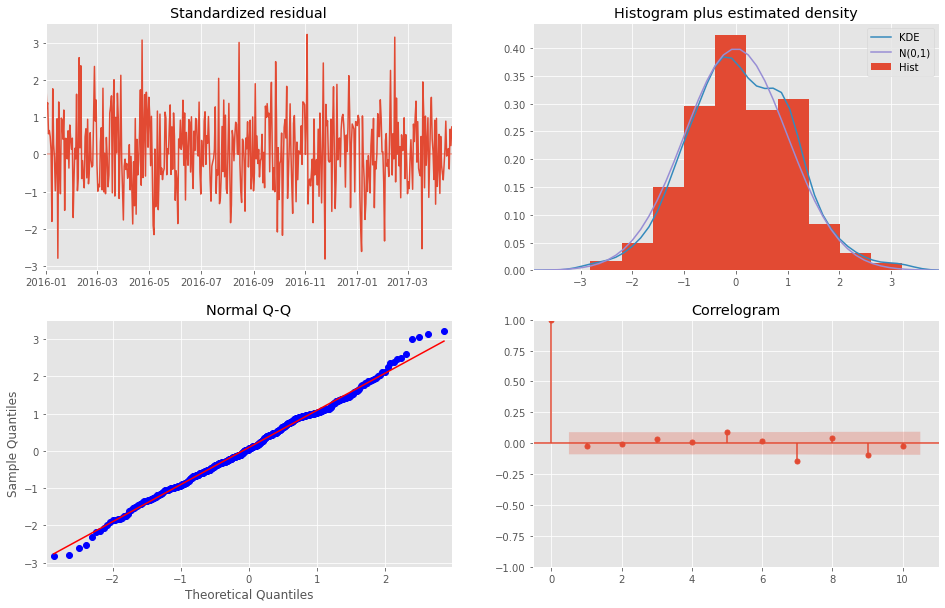

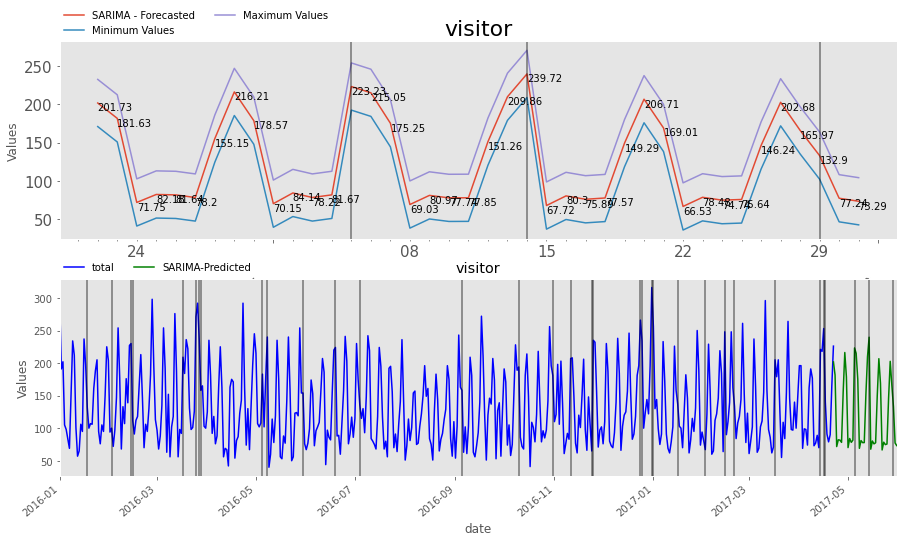

In [364]:
result_all = time_series.sarimax_model(df1,'total',order=(1,0,0),so=(2,0,0,7),title='visitor',exog=True,col_2='holiday',testing=False,n_pred=38,rmses=30.83,main_data_exo=df)